In [45]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TCFile import TCFile
import torchvision
import matplotlib.pyplot as plt
import utils

In [48]:
from utils.models.transforms import augmentation_transform_3d
import tifffile

class type_3d_dataset(Dataset):
    def __init__(self, root_dir, sample_D, transform=None, augmentation=False):
        
        self.data_path = []
        self.sample_D = sample_D
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'live']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathway)
            for i in os.listdir(pathway_dir):
                tif_path = os.path.join(pathway_dir, i)
                self.data_path.append((tif_path, pathway_label))
    
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        image, label = tifffile.imread(self.data_path[idx][0]), self.data_path[idx][1]
        image_tensor = torch.from_numpy(image)
        image_tensor = 255 * (image_tensor - torch.min(image_tensor))/(torch.max(image_tensor) - torch.min(image_tensor))
        image_tensor = image_tensor.to(torch.int)
        
        if image_tensor.shape[0] != self.sample_D:
            difference = image_tensor.shape[0] - self.sample_D
            image_tensor = image_tensor[difference//2 : image_tensor.shape[0]-difference//2, :, :]
        
        image_tensor = image_tensor.unsqueeze(1).repeat(1,3,1,1)
        
        # Prebuilt transform
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Rotation with edge mean filling
        if self.augmentation:
            image_tensor = augmentation_transform_3d(image_tensor)
            
        return image_tensor, label

In [2]:
from utils.models.transforms import augmentation_transform_3d
import tifffile

class type_3d_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False):
        
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'live']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathway)
            for i in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, i)
                image_3d = tifffile.imread(image_path)
                self.data.append((image_3d, pathway_label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_3d, label = self.data[idx][0], self.data[idx][1]
        image_tensor = torch.from_numpy(image_3d)
        image_tensor = 255 * (image_tensor - torch.min(image_tensor))/(torch.max(image_tensor) - torch.min(image_tensor))
        image_tensor = image_tensor.to(torch.int)
        image_tensor = image_tensor.unsqueeze(1).repeat(1,3,1,1)
        
        # Prebuilt transform
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Rotation with edge mean filling
        if self.augmentation:
            image_tensor = augmentation_transform_3d(image_tensor)
            
        return image_tensor, label

In [49]:
from utils import AugmentedDatasetWrapper
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\pathway_train_3d"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\pathway_test_3d"

# transform = models.video.R3D_18_Weights.KINETICS400_V1.transforms()
train_dataset = type_3d_dataset(train_dir, augmentation=True)
val_dataset = type_3d_dataset(val_dir, )
aug_train_dataset = AugmentedDatasetWrapper(train_dataset, num_repeats=2)

train_loader = DataLoader(dataset=aug_train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

TypeError: type_3d_dataset.__init__() missing 1 required positional argument: 'sample_D'

In [20]:
import utils

model = torchvision.models.video.r3d_18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

utils.print_trainable_parameters(model)

Total Parameters: 33,168,324
Trainable Parameters: 24,910,852


<h1> resnet50 </h1>

In [50]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TCFile import TCFile
import torchvision
import matplotlib.pyplot as plt
import utils

In [2]:
from models.transforms import augmentation_transform_3d
import tifffile

class type_3d_dataset(Dataset):
    def __init__(self, root_dir, sample_size, transform=None, augmentation=False):
        
        self.data = []
        self.sample_D = sample_size[0]
        self.sample_H = sample_size[1]
        self.sample_W = sample_size[2]
        self.min_ri_list = []
        self.max_ri_list = []
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'live']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathway)
            for i in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, i)
                image_3d = tifffile.imread(image_path)
                image_tensor = torch.from_numpy(image_3d).unsqueeze(0).unsqueeze(0)
                
                image_tensor = torch.nn.functional.interpolate(
                    image_tensor,
                    size=(self.sample_D, self.sample_H, self.sample_W),
                    mode='trilinear',
                    align_corners=False
                )
                
                image_tensor = image_tensor.squeeze(0).squeeze(0)
                self.min_ri_list.append(torch.min(image_tensor))
                self.max_ri_list.append(torch.max(image_tensor))
                self.data.append((image_tensor, pathway_label))

        self.min_ri = np.min(np.array(self.min_ri_list))
        self.max_ri = np.max(np.array(self.max_ri_list))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_tensor, label = self.data[idx][0], self.data[idx][1]
        image_tensor = 255 * (image_tensor - self.min_ri)/(self.max_ri - self.min_ri)
        image_tensor = image_tensor.to(torch.int)
        image_tensor = image_tensor.to(torch.float)
        
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.repeat(3,1,1,1)

        
        # Prebuilt transform
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Rotation with edge mean filling
        if self.augmentation:
            image_tensor = augmentation_transform_3d(image_tensor)
            
        return image_tensor, label

In [51]:
from utils.models.transforms import augmentation_transform_3d
import tifffile
import torchvision

class type_3d_dataset(Dataset):
    def __init__(self, root_dir, sample_size, transform=None, augmentation=False):
        
        self.data = []
        self.sample_D = sample_size[0]
        self.sample_H = sample_size[1]
        self.sample_W = sample_size[2]
        self.min_ri_list = []
        self.max_ri_list = []
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'live']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathway)
            for i in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, i)
                image_3d = tifffile.imread(image_path)
                image_tensor = torch.from_numpy(image_3d).unsqueeze(0).unsqueeze(0)
                
                image_tensor = torch.nn.functional.interpolate(
                    image_tensor,
                    size=(self.sample_D, self.sample_H, self.sample_W),
                    mode='trilinear',
                    align_corners=False
                )
                
                image_tensor = image_tensor.squeeze(0).squeeze(0)
                self.min_ri_list.append(torch.min(image_tensor))
                self.max_ri_list.append(torch.max(image_tensor))
                self.data.append((image_tensor, pathway_label))

        self.min_ri = np.min(np.array(self.min_ri_list))
        self.max_ri = np.max(np.array(self.max_ri_list))
        self.normalizer = torchvision.transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_tensor, label = self.data[idx][0], self.data[idx][1]
        
        # Step 1 : Rescale to [0.0, 1.0]
        image_tensor = (image_tensor - self.min_ri)/(self.max_ri - self.min_ri)

        # Step 2 : Make RGB channel - C
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.repeat(3,1,1,1) # (C, D, H, W)

        # Step 3: Normalize using RGB mean and std
        for c in range(3):
            image_tensor[c] = (image_tensor[c] - self.normalizer.mean[c]) / self.normalizer.std[c]

        
        # Prebuilt transform
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Rotation with edge mean filling
        if self.augmentation:
            image_tensor = augmentation_transform_3d(image_tensor)
            
        return image_tensor, label

In [52]:
import utils
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\pathway_train_3d"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\pathway_test_3d"

# transform = models.video.R3D_18_Weights.KINETICS400_V1.transforms()
train_dataset = type_3d_dataset(train_dir, (60, 112, 112), augmentation=True)
val_dataset = type_3d_dataset(val_dir, (60, 112, 112))
aug_train_dataset = utils.AugmentedDatasetWrapper(train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=aug_train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [114]:
train_dataset.min_ri, train_dataset.max_ri

(1.3207525, 1.4249475)

In [54]:
val_dataset.min_ri, val_dataset.max_ri

(1.32033, 1.4274234)

In [4]:
import utils
model = torchvision.models.video.r3d_18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

for name, params in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False

utils.models.print_trainable_parameters(model)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 33,168,324
Trainable Parameters: 24,910,852


In [4]:
import torch

# Load a pretrained slow_r50 (ResNet50) on Kinetics-400.
model = torch.hub.load("facebookresearch/pytorchvideo", "slow_r50", pretrained=True)

# The last linear layer is stored in model.blocks[-1].proj for slow_r50
in_features = model.blocks[-1].proj.in_features  # Should be 2048
model.blocks[-1].proj = torch.nn.Linear(in_features, 4)  # 4 classes
    
utils.print_trainable_parameters(model)

Using cache found in C:\Users\김민욱/.cache\torch\hub\facebookresearch_pytorchvideo_main


Total Parameters: 31,642,692
Trainable Parameters: 31,642,692


In [5]:
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [6]:
import utils

utils.models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, save_model=False)

  0%|          | 0/30 [00:00<?, ?it/s]c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)
  3%|▎         | 1/30 [01:01<29:35, 61.21s/it]

Epoch : 0
train loss : 0.115424 || train_acc : 0.1193
val loss : 0.077333 || val_acc : 0.4483


  7%|▋         | 2/30 [02:01<28:10, 60.38s/it]

Epoch : 1
train loss : 0.093987 || train_acc : 0.2418
val loss : 0.064868 || val_acc : 0.5172


 10%|█         | 3/30 [03:00<26:53, 59.76s/it]

Epoch : 2
train loss : 0.081920 || train_acc : 0.4248
val loss : 0.037460 || val_acc : 0.8506


 13%|█▎        | 4/30 [04:00<26:03, 60.12s/it]

Epoch : 3
train loss : 0.068819 || train_acc : 0.5327
val loss : 0.039683 || val_acc : 0.7241


 17%|█▋        | 5/30 [05:02<25:17, 60.70s/it]

Epoch : 4
train loss : 0.057556 || train_acc : 0.6389
val loss : 0.016020 || val_acc : 1.0000


 20%|██        | 6/30 [06:08<25:00, 62.52s/it]

Epoch : 5
train loss : 0.037378 || train_acc : 0.8105
val loss : 0.011024 || val_acc : 1.0000


 23%|██▎       | 7/30 [07:09<23:49, 62.13s/it]

Epoch : 6
train loss : 0.023395 || train_acc : 0.9003
val loss : 0.017683 || val_acc : 0.9540


 27%|██▋       | 8/30 [08:10<22:33, 61.54s/it]

Epoch : 7
train loss : 0.011528 || train_acc : 0.9837
val loss : 0.032806 || val_acc : 0.7356


 30%|███       | 9/30 [09:10<21:25, 61.23s/it]

Epoch : 8
train loss : 0.018404 || train_acc : 0.9134
val loss : 0.023871 || val_acc : 0.7931


 33%|███▎      | 10/30 [10:10<20:16, 60.80s/it]

Epoch : 9
train loss : 0.012367 || train_acc : 0.9788
val loss : 0.020875 || val_acc : 1.0000


 37%|███▋      | 11/30 [11:14<19:34, 61.81s/it]

Epoch : 10
train loss : 0.005724 || train_acc : 0.9902
val loss : 0.015327 || val_acc : 0.9655


 40%|████      | 12/30 [12:15<18:26, 61.49s/it]

Epoch : 11
train loss : 0.003861 || train_acc : 0.9935
val loss : 0.018466 || val_acc : 1.0000


 43%|████▎     | 13/30 [13:15<17:18, 61.07s/it]

Epoch : 12
train loss : 0.002478 || train_acc : 0.9984
val loss : 0.009031 || val_acc : 1.0000


 47%|████▋     | 14/30 [14:15<16:13, 60.84s/it]

Epoch : 13
train loss : 0.001077 || train_acc : 1.0000
val loss : 0.008828 || val_acc : 1.0000


 50%|█████     | 15/30 [15:16<15:13, 60.88s/it]

Epoch : 14
train loss : 0.000825 || train_acc : 1.0000
val loss : 0.008720 || val_acc : 1.0000


 53%|█████▎    | 16/30 [16:19<14:21, 61.55s/it]

Epoch : 15
train loss : 0.000669 || train_acc : 1.0000
val loss : 0.008980 || val_acc : 1.0000


 57%|█████▋    | 17/30 [17:20<13:17, 61.32s/it]

Epoch : 16
train loss : 0.000555 || train_acc : 1.0000
val loss : 0.008575 || val_acc : 1.0000


 60%|██████    | 18/30 [18:21<12:13, 61.12s/it]

Epoch : 17
train loss : 0.000508 || train_acc : 1.0000
val loss : 0.008979 || val_acc : 1.0000


 63%|██████▎   | 19/30 [19:21<11:08, 60.75s/it]

Epoch : 18
train loss : 0.000492 || train_acc : 1.0000
val loss : 0.008234 || val_acc : 1.0000


 67%|██████▋   | 20/30 [20:25<10:18, 61.83s/it]

Epoch : 19
train loss : 0.000411 || train_acc : 1.0000
val loss : 0.007582 || val_acc : 1.0000


 70%|███████   | 21/30 [21:26<09:13, 61.51s/it]

Epoch : 20
train loss : 0.000369 || train_acc : 1.0000
val loss : 0.008108 || val_acc : 1.0000


 73%|███████▎  | 22/30 [22:27<08:11, 61.41s/it]

Epoch : 21
train loss : 0.000470 || train_acc : 1.0000
val loss : 0.006398 || val_acc : 1.0000


 77%|███████▋  | 23/30 [23:27<07:06, 61.00s/it]

Epoch : 22
train loss : 0.000434 || train_acc : 1.0000
val loss : 0.007647 || val_acc : 1.0000


 80%|████████  | 24/30 [24:26<06:02, 60.37s/it]

Epoch : 23
train loss : 0.000314 || train_acc : 1.0000
val loss : 0.007216 || val_acc : 1.0000


 83%|████████▎ | 25/30 [25:28<05:04, 60.94s/it]

Epoch : 24
train loss : 0.000278 || train_acc : 1.0000
val loss : 0.007460 || val_acc : 1.0000


 87%|████████▋ | 26/30 [26:28<04:01, 60.47s/it]

Epoch : 25
train loss : 0.000235 || train_acc : 1.0000
val loss : 0.007505 || val_acc : 1.0000


 90%|█████████ | 27/30 [27:27<03:00, 60.19s/it]

Epoch : 26
train loss : 0.000346 || train_acc : 1.0000
val loss : 0.007531 || val_acc : 1.0000


 93%|█████████▎| 28/30 [28:26<01:59, 59.68s/it]

Epoch : 27
train loss : 0.001466 || train_acc : 0.9967
val loss : 0.007141 || val_acc : 1.0000


 97%|█████████▋| 29/30 [29:26<00:59, 59.88s/it]

Epoch : 28
train loss : 0.002138 || train_acc : 0.9951
val loss : 0.009052 || val_acc : 1.0000


100%|██████████| 30/30 [30:30<00:00, 61.02s/it]

Epoch : 29
train loss : 0.000751 || train_acc : 1.0000
val loss : 0.006741 || val_acc : 1.0000


<h1> Confusion matrix </h1>

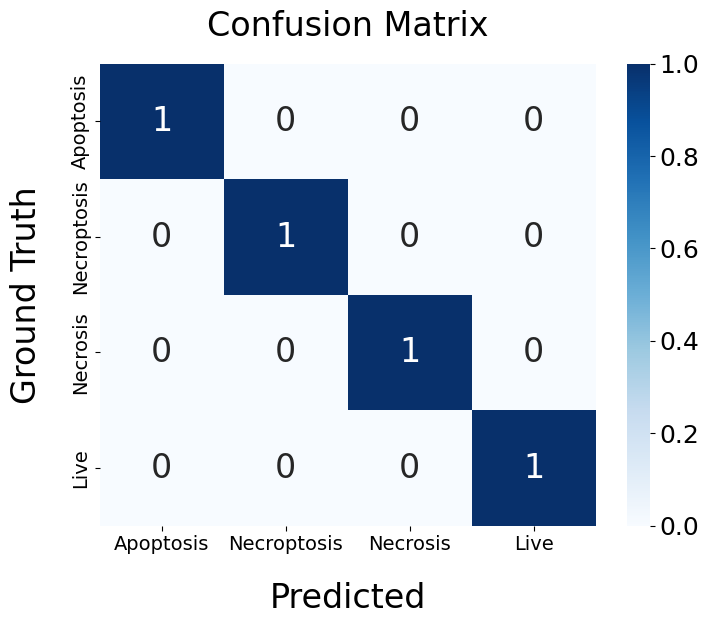

In [8]:
import utils

utils.confusion_matrix(model, val_loader)

<h1> Timelapse </h1>

In [110]:
import torch
from TCFile import TCFile
import numpy as np

path = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\241126.155819.hela_none_PP2.001.Group1.A1.T001P09.TCF"
file = TCFile(path, '3D')

stack = []
for f in file:
    temp = torch.from_numpy(f[:, 0:480, 0:480])
    temp = temp.unsqueeze(0).unsqueeze(0)
    
    fz = file.data_resolution[0]/0.1632
    fy = file.data_resolution[1]/0.1632
    fx = file.data_resolution[2]/0.1632
            
    temp = torch.nn.functional.interpolate(
        temp, scale_factor=(fz, fy, fx), mode='trilinear', align_corners=False
    )

    temp = torch.nn.functional.interpolate(temp, size=(60, 112, 112), mode='trilinear', align_corners=False)
    temp = temp.squeeze(0).squeeze(0)
    stack.append(temp)

In [96]:
import torchvision

model = torchvision.models.video.r3d_18()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v1\r3d_18_7-3_3d_val_acc_1.0000.pth"))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_20184\2561026194.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_deat

<All keys matched successfully>

In [102]:
min_ri, max_ri = 1.32033, 1.4274234

In [111]:
import torchvision 

model = model.cuda()
model.eval()
normalizer = torchvision.transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])

with torch.no_grad():
    apoptosis_prob = []
    necroptosis_prob = []
    necrosis_prob = []
    live_prob = []
    
    for s in stack:
        N = len(stack)
        death_probability = 0
        output_list = []
        
        s = s.cuda()
        
        # Step 1 : Rescale to [0.0, 1.0]
        s = (s - min_ri)/(max_ri - min_ri)
            
        # Step 2 : Make RGB channel - C
        s = s.unsqueeze(0)
        s = s.repeat(3,1,1,1) # (C, D, H, W)

        # Step 3: Normalize using RGB mean and std
        for c in range(3):
            s[c] = (s[c] - normalizer.mean[c]) / normalizer.std[c]
                
        output = model(s.unsqueeze(0).cuda())
        output_prob = torch.nn.functional.softmax(output)
        
        apoptosis_prob.append(float(output_prob[0][0].cpu()))
        necroptosis_prob.append(float(output_prob[0][1].cpu()))
        necrosis_prob.append(float(output_prob[0][2].cpu()))
        live_prob.append(float(output_prob[0][3].cpu()))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_20184\1903360196.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_prob = torch.nn.functional.softmax(output)


In [112]:
output_prob

tensor([[0.0316, 0.0381, 0.0052, 0.9251]], device='cuda:0')

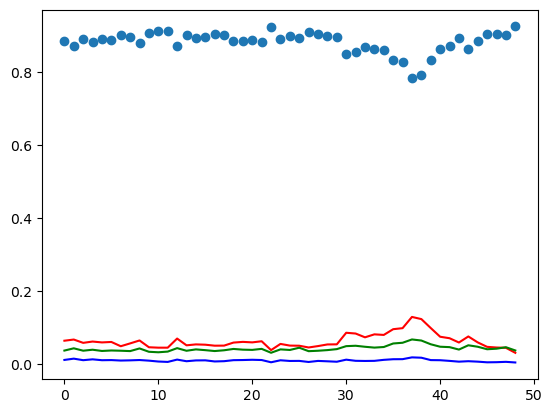

In [113]:
import matplotlib.pyplot as plt

plt.plot(apoptosis_prob, 'r')
plt.plot(necroptosis_prob, 'g')
plt.plot(necrosis_prob, 'b')
plt.plot(live_prob, 'o')

In [17]:
output_prob

tensor([[0.2410, 0.3000, 0.2758, 0.1833]], device='cuda:0')

In [25]:
float(output_prob[0][1].cpu())

0.2999778985977173

In [16]:
probabilities

[0.005493477303931054,
 0.0057067934502946565,
 0.005613242058043784,
 0.005584210157394409,
 0.005898829470289514,
 0.005923929366659611,
 0.005825907626050584,
 0.005933689310195598,
 0.005603427582598747,
 0.005423197720913177,
 0.0056925517447451324,
 0.005308491752502766,
 0.005370945372480027,
 0.005533048447142256,
 0.0054502182818473655,
 0.005669045955576795,
 0.005698610493477354,
 0.006024609220788834,
 0.006012246963825632,
 0.005721300840377808,
 0.005880053373093301,
 0.006039836305253049,
 0.005923333320211857,
 0.006149494901616523,
 0.005944618519316328,
 0.006027616084890163,
 0.00632642685098851,
 0.006312265675118629,
 0.00597508283371621,
 0.006235534206349799,
 0.0063690245151519775,
 0.006044101841906284,
 0.006460927268292041,
 0.006274956337949063,
 0.0062400159683633355,
 0.006311376678182724,
 0.006519486295416,
 0.006609765773123884,
 0.006368909744506187,
 0.006441810029618284,
 0.006401833067549036,
 0.006338434650542888,
 0.0063611757248005964,
 0.0065274